In [3]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2024-09-06 12:56:38--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  3.79MB/s    in 15s     

2024-09-06 12:56:53 (4.19 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [41]:
import dlib
import glob
import csv
from skimage import io
import torch
import os
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from torchvision import transforms

In [42]:
"""Create a sample face landmarks dataset.

Adapted from dlib/python_examples/face_landmark_detection.py
See this file for more explanation.

Download a trained facial shape predictor from:
    http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
"""


detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
num_landmarks = 68
path = 'Datasets/**/*.jpg'
with open('face_landmarks.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)


    header = ['image_name']
    for i in range(num_landmarks):
        header += ['part_{}_x'.format(i), 'part_{}_y'.format(i)]

    csv_writer.writerow(header)

    for f in glob.glob(path, recursive=True):
        img = io.imread(f)
        dets = detector(img, 1)  # face detection

        # ignore all the files with no or more than one faces detected.
        if len(dets) == 1:
            row = [f]

            d = dets[0]
            # Get the landmarks/parts for the face in box d.
            shape = predictor(img, d)
            for i in range(num_landmarks):
                part_i_x = shape.part(i).x
                part_i_y = shape.part(i).y
                row += [part_i_x, part_i_y]

            csv_writer.writerow(row)

In [60]:
import pandas as pd
import numpy as np
landmarks_frame = pd.read_csv('face_landmarks.csv')

n = 1700
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks, dtype=float).reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: Datasets/gopi/face_320_1320.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[  4.  69.]
 [  7.  93.]
 [ 12. 117.]
 [ 20. 139.]]


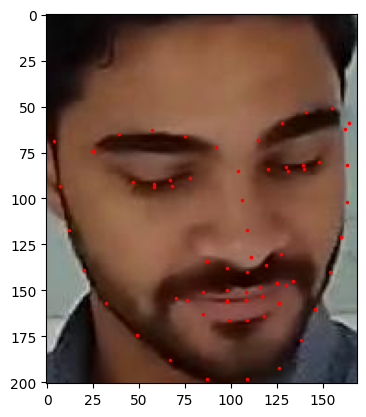

In [61]:
import matplotlib.pyplot as plt
import os
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('./', img_name)),
               landmarks)
plt.show()

In [62]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
 
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks], dtype=float).reshape(-1, 2)
    
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (41, 37, 3) (68, 2)


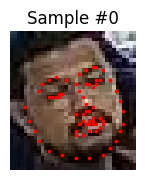

1 (42, 37, 3) (68, 2)


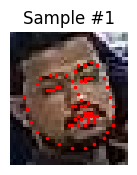

2 (42, 37, 3) (68, 2)


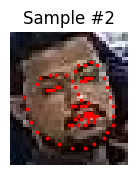

3 (42, 37, 3) (68, 2)


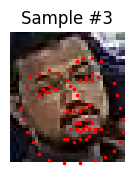

In [63]:
face_dataset = FaceLandmarksDataset(csv_file='face_landmarks.csv',
                                    root_dir='./')

fig = plt.figure()

for i, sample in enumerate(face_dataset):
    print(i, sample['image'].shape, sample['landmarks'].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [64]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

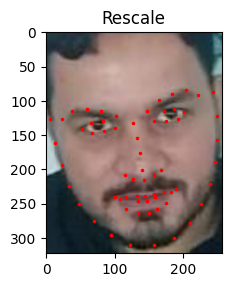

ValueError: high <= 0

In [65]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[61]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [24]:
transformed_dataset = FaceLandmarksDataset(csv_file='face_landmarks.csv',
                                           root_dir='./',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ],),)

for i, sample in enumerate(transformed_dataset):
    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


In [12]:
torch.__version__

'2.2.2+cu121'

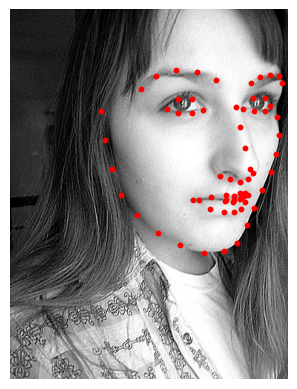

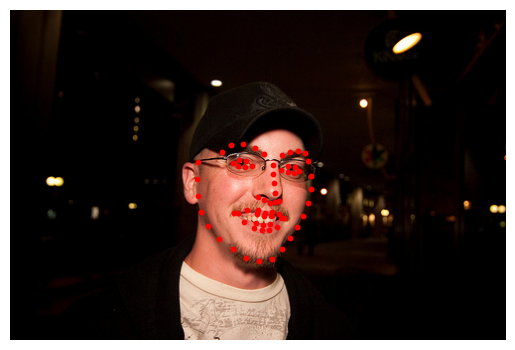

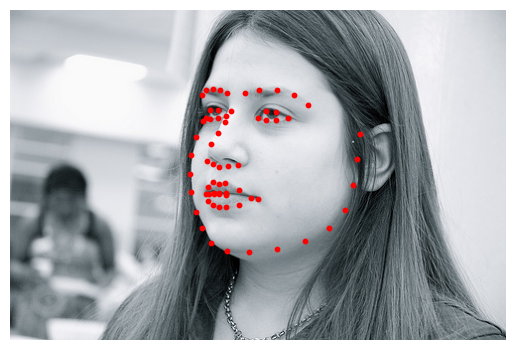

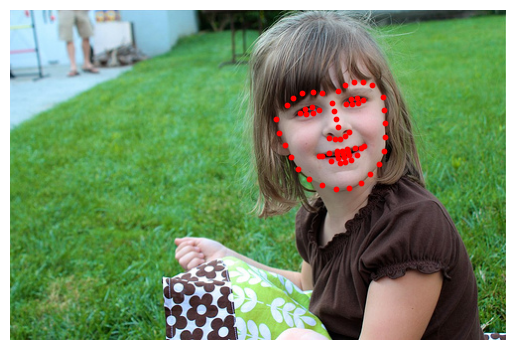

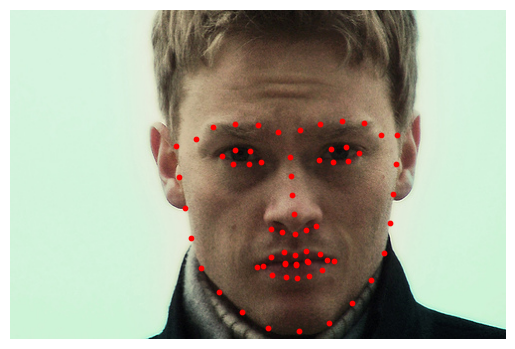

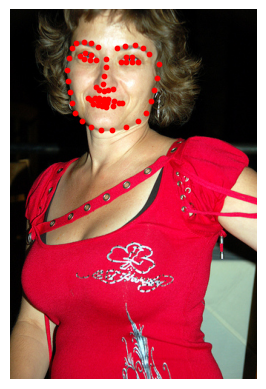

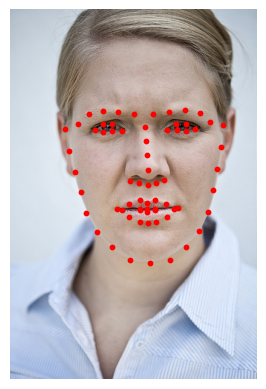

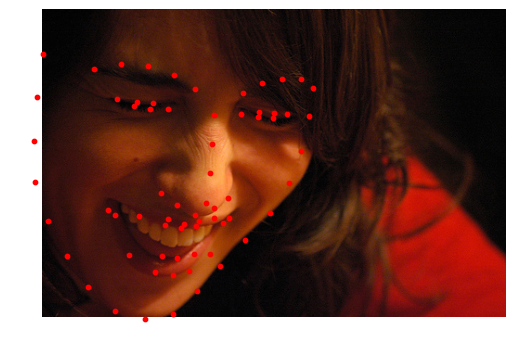

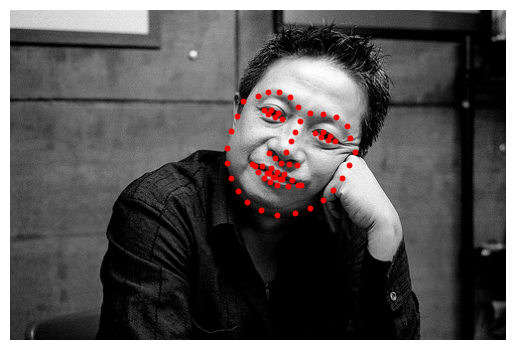

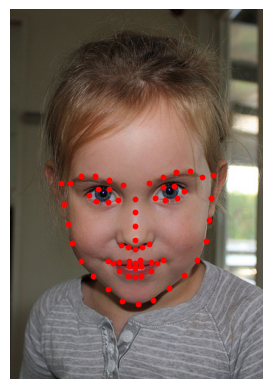

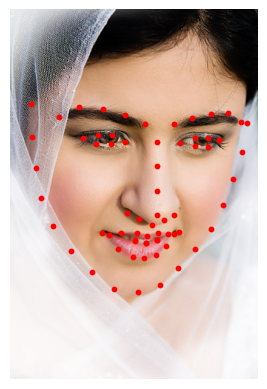

In [7]:
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd

# Path to the CSV file and images directory
directory = './'  # Replace with your local directory path
csv_file_path = os.path.join(directory, 'face_landmarks.csv')

# Load the CSV file
landmarks_df = pd.read_csv(csv_file_path)

# Function to plot landmarks on an image
def plot_landmarks(image_path, landmarks):
    # Load the image
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Error: Unable to load image {image_path}")
        return
    
    # Convert image to RGB (OpenCV loads images in BGR format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Plot the image
    plt.imshow(image_rgb)
    
    # Plot the landmarks
    num_landmarks = len(landmarks) // 2  # Each landmark has x and y
    for i in range(num_landmarks):
        x, y = landmarks[2 * i], landmarks[2 * i + 1]
        plt.scatter(x, y, s=10, c='red', marker='o')

    plt.axis('off')  # Hide axis
    plt.show()

# Iterate through the dataframe to read each image and its corresponding landmarks
for index, row in landmarks_df.iterrows():
    image_name = row['image_name']
    image_path = os.path.join(directory, image_name)

    # Extract landmarks from the row (all columns except the first one)
    landmarks = row[1:].values

    # Plot the image with landmarks
    plot_landmarks(image_path, landmarks)

    # For demonstration purposes, you can limit the number of images displayed
    if index >= 10:  # Adjust or remove this line as needed
        break
